<a href="https://colab.research.google.com/github/xymeo/mnist-handwriting-recognition/blob/main/handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is to compare the accuracy of recognizing handwritten numbers, by training on the MNIST dataset two models - Convolutional Neural Networks and Multi Layered Perceptrons. 

The loss generated per epoch, and training and validation accuracies are compared for both models.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

# The Dataset

We create the transforms for training and validation, create training and validation datasets, and Dataloaders. 

In [3]:
batch_size = 64
transform_training = transforms.Compose([
                                        # transforms.RandomAffine(degrees=(20),
                                        #                         translate=(0.1, 0.1), 
                                        #                         scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1310), (0.3085)),
                                        # transforms.Normalize((0.5), (0.5)),
                                        ])
transform_validation = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1310), (0.3085)),
                                        # transforms.Normalize((0.5), (0.5)),
                                        ])
training_set = datasets.MNIST(root="data", train=True, download=True, transform=transform_training)
validation_set = datasets.MNIST(root="data", train=False, download=True, transform=transform_validation)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_set, batch_size=batch_size)

### Visualizing the data and associated labels 

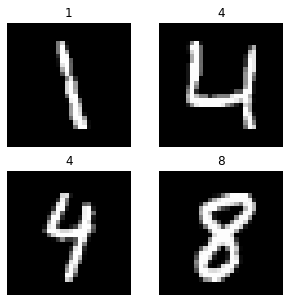

In [6]:
figure = plt.figure(figsize=(5, 5))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_set), size=(1,)).item()
    img, label = training_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating Models



### Defining the Convolutional Neural Network (CNN)

In [7]:
class CNN(nn.Module):
  def __init__(self):
    
    super().__init__()
    
    self.conv_block = nn.Sequential(
      # 1st Conv Block 
      nn.Conv2d(in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=2),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),
      nn.Dropout(0.2),

      # 2nd Conv Block 
      nn.Conv2d(in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1,                   
                padding=2),
      nn.MaxPool2d(2, 2),
      nn.ReLU(),)
    
    self.fc1 = nn.Linear(2048, 10)
      
    
  def forward(self,x): 
    x = self.conv_block(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    return x


cnn = CNN() 
cnn


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

### Defining the Multi Layered Perceptron (MLP)

In [8]:
class Net(nn.Module):
  def __init__(self):
     super().__init__()
     self.activation = F.relu
     self.hl1 = nn.Linear(28*28, 128)
     self.hl2 = nn.Linear(128, 64)
     self.hl3 = nn.Linear(64, 10)


  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.activation(self.hl1(x))
    x = self.activation(self.hl2(x))
    x = self.hl3(x)
    return x 

mlp = Net()
mlp

Net(
  (hl1): Linear(in_features=784, out_features=128, bias=True)
  (hl2): Linear(in_features=128, out_features=64, bias=True)
  (hl3): Linear(in_features=64, out_features=10, bias=True)
)

### Defining Loss Function and Learning Rate

In [10]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training the Model 

In [11]:
def training_loop(model, learning_rate, num_epochs=20):

  training_loss_history, val_loss_history = [], []
  training_acc_history, val_acc_history = [], []

  # defining the Optimizer 
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  if torch.cuda.is_available():
    model = model.cuda() # Enable GPU 
  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      train_correct = 0 # Number of correct predictions in training set
      training_acc = 0.0
      
      for i, data in enumerate(tqdm(train_loader)):
          inputs, labels = data
          if torch.cuda.is_available():  # Enable GPU if available
              inputs, labels = inputs.cuda(), labels.cuda()
              
          optimizer.zero_grad() # Set gradients of all weights to 0 
          outputs = model(inputs) # Get the output 
          loss = loss_function(outputs, labels) # Calculate loss agains labels 
          loss.backward() # Calculate dloss/dx for parameters x 
          optimizer.step() # Parameter update

          _, preds = torch.max(outputs.data, 1)
          train_correct += (preds == labels).sum().item()
          train_loss += loss.item()
        
      training_acc = train_correct * 100 /len(training_set)
      print(f'Epoch {epoch + 1} training accuracy: {training_acc:.2f}% training loss: {train_loss/len(training_set):.5f}')
      training_loss_history.append(train_loss/len(training_set))
      training_acc_history.append(training_acc)

      val_loss = 0.0
      val_correct = 0 # Number of correct predictions in training set
      validation_acc = 0.0
      with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs) # Get output
            loss = loss_function(outputs, labels) 

            _, preds = torch.max(outputs.data, 1)
            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
      
      validation_acc = val_correct * 100 /len(validation_set)
      print(f'Epoch {epoch + 1} validation accuracy: {validation_acc:.2f}% validation loss: {val_loss/len(validation_set):.5f}')
      val_loss_history.append(val_loss/len(validation_set))
      val_acc_history.append(validation_acc)

  return training_loss_history, val_loss_history, training_acc_history, val_acc_history

### Training on CNN 

In [12]:
training_loss_history_cnn, val_loss_history_cnn, training_acc_history_cnn, val_acc_history_cnn = training_loop(cnn, learning_rate=learning_rate)

100%|██████████| 938/938 [00:18<00:00, 50.00it/s]


Epoch 1 training accuracy: 94.00% training loss: 0.00319
Epoch 1 validation accuracy: 98.06% validation loss: 0.00103


100%|██████████| 938/938 [00:11<00:00, 80.40it/s]


Epoch 2 training accuracy: 97.85% training loss: 0.00111
Epoch 2 validation accuracy: 98.34% validation loss: 0.00078


100%|██████████| 938/938 [00:11<00:00, 78.51it/s]


Epoch 3 training accuracy: 98.36% training loss: 0.00082
Epoch 3 validation accuracy: 98.88% validation loss: 0.00054


100%|██████████| 938/938 [00:11<00:00, 79.24it/s]


Epoch 4 training accuracy: 98.62% training loss: 0.00069
Epoch 4 validation accuracy: 98.98% validation loss: 0.00054


100%|██████████| 938/938 [00:11<00:00, 79.96it/s]


Epoch 5 training accuracy: 98.79% training loss: 0.00059
Epoch 5 validation accuracy: 98.73% validation loss: 0.00056


100%|██████████| 938/938 [00:11<00:00, 79.03it/s]


Epoch 6 training accuracy: 98.92% training loss: 0.00052
Epoch 6 validation accuracy: 98.99% validation loss: 0.00050


100%|██████████| 938/938 [00:12<00:00, 75.68it/s]


Epoch 7 training accuracy: 99.03% training loss: 0.00046
Epoch 7 validation accuracy: 98.89% validation loss: 0.00052


100%|██████████| 938/938 [00:11<00:00, 80.48it/s]


Epoch 8 training accuracy: 99.12% training loss: 0.00042
Epoch 8 validation accuracy: 99.08% validation loss: 0.00046


100%|██████████| 938/938 [00:11<00:00, 78.57it/s]


Epoch 9 training accuracy: 99.24% training loss: 0.00036
Epoch 9 validation accuracy: 98.94% validation loss: 0.00051


100%|██████████| 938/938 [00:11<00:00, 79.18it/s]


Epoch 10 training accuracy: 99.27% training loss: 0.00035
Epoch 10 validation accuracy: 99.04% validation loss: 0.00045


100%|██████████| 938/938 [00:11<00:00, 78.85it/s]


Epoch 11 training accuracy: 99.31% training loss: 0.00032
Epoch 11 validation accuracy: 99.01% validation loss: 0.00045


100%|██████████| 938/938 [00:11<00:00, 80.49it/s]


Epoch 12 training accuracy: 99.33% training loss: 0.00029
Epoch 12 validation accuracy: 99.05% validation loss: 0.00047


100%|██████████| 938/938 [00:11<00:00, 79.46it/s]


Epoch 13 training accuracy: 99.38% training loss: 0.00028
Epoch 13 validation accuracy: 98.93% validation loss: 0.00055


100%|██████████| 938/938 [00:11<00:00, 80.37it/s]


Epoch 14 training accuracy: 99.43% training loss: 0.00027
Epoch 14 validation accuracy: 98.90% validation loss: 0.00050


100%|██████████| 938/938 [00:11<00:00, 79.40it/s]


Epoch 15 training accuracy: 99.46% training loss: 0.00025
Epoch 15 validation accuracy: 99.05% validation loss: 0.00051


100%|██████████| 938/938 [00:11<00:00, 78.59it/s]


Epoch 16 training accuracy: 99.51% training loss: 0.00022
Epoch 16 validation accuracy: 99.03% validation loss: 0.00047


100%|██████████| 938/938 [00:11<00:00, 80.29it/s]


Epoch 17 training accuracy: 99.52% training loss: 0.00021
Epoch 17 validation accuracy: 99.10% validation loss: 0.00057


100%|██████████| 938/938 [00:11<00:00, 78.59it/s]


Epoch 18 training accuracy: 99.55% training loss: 0.00021
Epoch 18 validation accuracy: 99.06% validation loss: 0.00049


100%|██████████| 938/938 [00:11<00:00, 80.71it/s]


Epoch 19 training accuracy: 99.57% training loss: 0.00019
Epoch 19 validation accuracy: 99.02% validation loss: 0.00053


100%|██████████| 938/938 [00:11<00:00, 79.14it/s]


Epoch 20 training accuracy: 99.56% training loss: 0.00019
Epoch 20 validation accuracy: 99.09% validation loss: 0.00051


### Training on MLP  

In [13]:
training_loss_history_mlp, val_loss_history_mlp, training_acc_history_mlp, val_acc_history_mlp = training_loop(mlp, learning_rate=learning_rate)

100%|██████████| 938/938 [00:11<00:00, 85.06it/s]


Epoch 1 training accuracy: 91.63% training loss: 0.00434
Epoch 1 validation accuracy: 95.26% validation loss: 0.00228


100%|██████████| 938/938 [00:11<00:00, 83.02it/s]


Epoch 2 training accuracy: 96.37% training loss: 0.00187
Epoch 2 validation accuracy: 96.81% validation loss: 0.00161


100%|██████████| 938/938 [00:11<00:00, 82.28it/s]


Epoch 3 training accuracy: 97.30% training loss: 0.00131
Epoch 3 validation accuracy: 97.24% validation loss: 0.00139


100%|██████████| 938/938 [00:11<00:00, 85.03it/s]


Epoch 4 training accuracy: 97.96% training loss: 0.00101
Epoch 4 validation accuracy: 97.56% validation loss: 0.00116


100%|██████████| 938/938 [00:11<00:00, 84.68it/s]


Epoch 5 training accuracy: 98.42% training loss: 0.00079
Epoch 5 validation accuracy: 97.55% validation loss: 0.00127


100%|██████████| 938/938 [00:11<00:00, 84.12it/s]


Epoch 6 training accuracy: 98.68% training loss: 0.00064
Epoch 6 validation accuracy: 97.64% validation loss: 0.00126


100%|██████████| 938/938 [00:11<00:00, 83.96it/s]


Epoch 7 training accuracy: 98.87% training loss: 0.00054
Epoch 7 validation accuracy: 97.52% validation loss: 0.00140


100%|██████████| 938/938 [00:11<00:00, 84.92it/s]


Epoch 8 training accuracy: 98.99% training loss: 0.00047
Epoch 8 validation accuracy: 97.56% validation loss: 0.00139


100%|██████████| 938/938 [00:11<00:00, 83.03it/s]


Epoch 9 training accuracy: 99.09% training loss: 0.00041
Epoch 9 validation accuracy: 97.86% validation loss: 0.00120


100%|██████████| 938/938 [00:10<00:00, 85.54it/s]


Epoch 10 training accuracy: 99.25% training loss: 0.00035
Epoch 10 validation accuracy: 97.77% validation loss: 0.00130


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]


Epoch 11 training accuracy: 99.20% training loss: 0.00036
Epoch 11 validation accuracy: 97.79% validation loss: 0.00138


100%|██████████| 938/938 [00:11<00:00, 80.02it/s]


Epoch 12 training accuracy: 99.38% training loss: 0.00029
Epoch 12 validation accuracy: 97.66% validation loss: 0.00154


100%|██████████| 938/938 [00:11<00:00, 84.29it/s]


Epoch 13 training accuracy: 99.44% training loss: 0.00026
Epoch 13 validation accuracy: 97.72% validation loss: 0.00144


100%|██████████| 938/938 [00:11<00:00, 83.66it/s]


Epoch 14 training accuracy: 99.49% training loss: 0.00025
Epoch 14 validation accuracy: 97.80% validation loss: 0.00157


100%|██████████| 938/938 [00:14<00:00, 64.19it/s]


Epoch 15 training accuracy: 99.51% training loss: 0.00023
Epoch 15 validation accuracy: 97.91% validation loss: 0.00144


100%|██████████| 938/938 [00:11<00:00, 83.66it/s]


Epoch 16 training accuracy: 99.53% training loss: 0.00024
Epoch 16 validation accuracy: 97.89% validation loss: 0.00156


100%|██████████| 938/938 [00:10<00:00, 85.97it/s]


Epoch 17 training accuracy: 99.51% training loss: 0.00024
Epoch 17 validation accuracy: 97.95% validation loss: 0.00160


100%|██████████| 938/938 [00:11<00:00, 84.03it/s]


Epoch 18 training accuracy: 99.57% training loss: 0.00021
Epoch 18 validation accuracy: 97.73% validation loss: 0.00192


100%|██████████| 938/938 [00:11<00:00, 84.36it/s]


Epoch 19 training accuracy: 99.55% training loss: 0.00022
Epoch 19 validation accuracy: 97.94% validation loss: 0.00174


100%|██████████| 938/938 [00:11<00:00, 82.84it/s]


Epoch 20 training accuracy: 99.60% training loss: 0.00017
Epoch 20 validation accuracy: 97.50% validation loss: 0.00222


# Visualizing Loss and Model Accuracy 

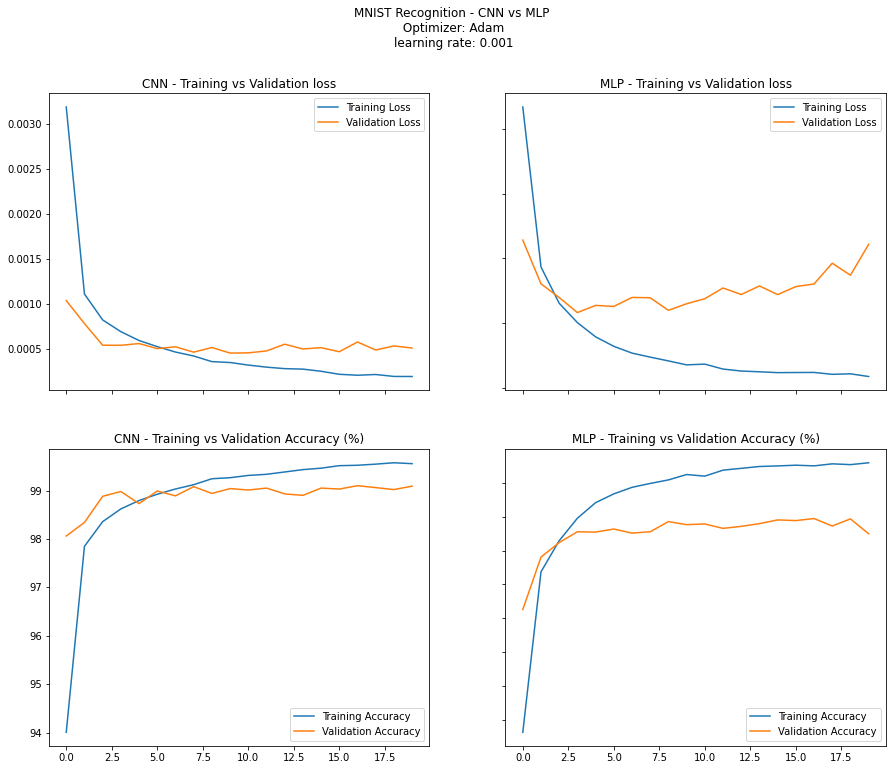

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(15,12))
fig.suptitle('MNIST Recognition - CNN vs MLP \n Optimizer: Adam \nlearning rate: '+ format(learning_rate))

# CNN Model Loss 
ax1.plot(training_loss_history_cnn, label="Training Loss")
ax1.plot(val_loss_history_cnn, label="Validation Loss")
ax1.title.set_text('CNN - Training vs Validation loss')
ax1.legend()

# CNN Model Accuracy 
ax3.plot(training_acc_history_cnn, label="Training Accuracy")
ax3.plot(val_acc_history_cnn, label="Validation Accuracy")
ax3.title.set_text('CNN - Training vs Validation Accuracy (%)')
ax3.legend()


# MLP Model Loss 
ax2.plot(training_loss_history_mlp, label="Training Loss")
ax2.plot(val_loss_history_mlp, label="Validation Loss")
ax2.title.set_text('MLP - Training vs Validation loss')
ax2.legend()


# MLP Model Accuracy 
ax4.plot(training_acc_history_mlp, label="Training Accuracy")
ax4.plot(val_acc_history_mlp, label="Validation Accuracy")
ax4.title.set_text('MLP - Training vs Validation Accuracy (%)')
ax4.legend()


for ax in fig.get_axes():
    ax.label_outer()
